In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import itertools

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
from scipy.sparse import csgraph
import pandas as pd

import graphsemnet.gsn_recursive as gsn
import graphsemnet.semantics as sem

In [2]:
sns.set(font_scale=1.5)

# Agent-based simulation

In [3]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [4]:
def interp_matrices(x, y, interp):
    return x - (x - y) * interp

In [17]:
class Agent(object):
    def __init__(self, id_string, graph, learning_rate=.2):
        print(f"\"Hello world, I'm {id_string}.\"")
        self.id_string = id_string
        self.graph = graph
        self.learning_rate = learning_rate
        self.episode_graph = None
        
    def start_episode(self):
        print(f"{self.id_string} is listening")
        self.episode_graph = copy.deepcopy(self.graph)
    
    def end_episode(self):
        print(f"{self.id_string} stopped listening")
        self.graph.adj = interp_matrices(self.graph.adj, self.episode_graph.adj, self.learning_rate)
        self.episode_graph = None
    
    def send(self, receivers, words):
        print(f"{self.id_string} says \"{' '.join(words)}\"")
        for receiver in receivers:
            receiver.receive(words)
            
    def receive(self, words):
        print(f"{self.id_string} received {words}")
        if self.episode_graph is None:
            print(f"{self.id_string} wasn't listening")
            return
        for word in words:
            if word not in self.graph.labels:
                print(f"{self.id_string} doesn't know the word \"{word}\"")
        words = [word for word in words if word in self.graph.labels]
        print(f"{self.id_string} updated their episode graph weights")
        self.episode_graph.activate_words(words)
        
    def spontaneous_words(self, n=2):
        assert self.episode_graph is not None
        mean_in = np.mean(self.episode_graph.adj, axis=0)
        distribution = mean_in / np.sum(mean_in)
        return np.random.choice(self.episode_graph.labels, size=n, p=distribution, replace=False)

## Mnemonic convergence of two agents

In [18]:
words_a = [
    'income',
    'inequality',
    'wealthy',
    'rich',
    'poor',
    'tax',
    'liberal',
    'conservative'
]
dsm_a = sem.semantic_dsm(words_a, google_news)
graph_a = gsn.SemanticGraph(word_dsm=dsm_a, labels=words_a)

In [19]:
dsm_a_shuffled = copy.copy(dsm_a)
np.random.shuffle(dsm_a_shuffled)
graph_b = gsn.SemanticGraph(word_dsm=dsm_a_shuffled, labels=words_a)

In [20]:
alice = Agent('Alice', graph=copy.deepcopy(graph_a), learning_rate=.5)
bob = Agent('Bob', graph=copy.deepcopy(graph_b), learning_rate=.5)

"Hello world, I'm Alice."
"Hello world, I'm Bob."


In [21]:
alice.start_episode()
bob.start_episode()

Alice is listening
Bob is listening


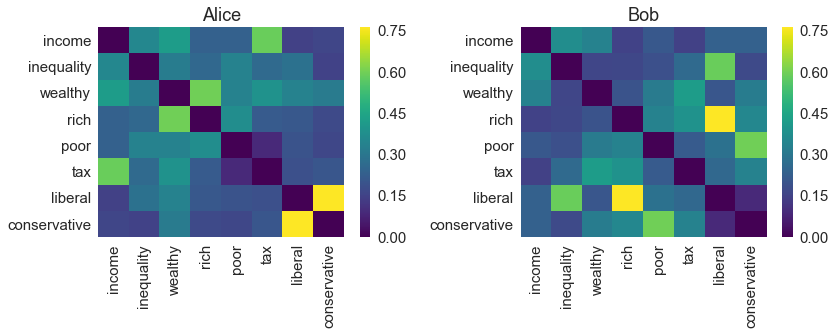

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(
    alice.episode_graph.adj, 
    xticklabels=alice.episode_graph.labels, 
    yticklabels=alice.episode_graph.labels, 
    cmap='viridis',
    ax=ax1,
)
ax1.set_title('Alice')

sns.heatmap(
    bob.episode_graph.adj, 
    xticklabels=bob.episode_graph.labels, 
    yticklabels=bob.episode_graph.labels, 
    cmap='viridis',
    ax=ax2
)
ax2.set_title('Bob')
plt.tight_layout()

In [ ]:
n_simulations = 1000
n_exchanges = 25

sim_distances = []

for s in range(n_simulations):
    
    alice = Agent('Alice', graph=copy.deepcopy(graph_a), learning_rate=.5)
    bob = Agent('Bob', graph=copy.deepcopy(graph_b), learning_rate=.5)
    
    alice.start_episode()
    bob.start_episode()

    distance = []

    for t in range(n_exchanges):
        r = dist.correlation(dist.squareform(alice.episode_graph.adj), dist.squareform(bob.episode_graph.adj))
        distance.append(r)
        print(f"   - distance(alice, bob): {r}")
        words = alice.spontaneous_words(2)
        alice.send(receivers=[bob], words=words)
        words = bob.spontaneous_words(2)
        bob.send(receivers=[alice], words=words)
        
    sim_distances.append(distance)

"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3135036435757534
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1774768850927042
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1544726453276744
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph we

   - distance(alice, bob): 1.0835284992431031
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0898957945649197
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1018017704511953
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1352607381311788
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their epis

Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0585322468272087
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.039930053484803
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0907783922213197
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1002050011712967
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "rich tax"
Alice receive

Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2307899051440878
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1359852659194447
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated 

Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9528412634845158
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9775465461972986
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9777587982890188
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is

Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2567814672316326
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1897089914918468
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1582492124142378
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.116143896504001
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob upd

Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9637504419250247
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.966696467327582
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9735598845618809
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9181142510035669
Alice says "conserv

Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.105812569276975
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1095131775949367
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1710334153590165
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1419508794921351
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob say

Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0428605650554021
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0381974407949401
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0661280380513183
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0594954758425421
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob up

   - distance(alice, bob): 1.3203632536058898
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.224108956482721
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2065417716272753
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2772140824813438
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - di

Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0810074385004036
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0921785825961565
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.031295529766487
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9654411787959387
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice r

Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2698929640104855
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2196149652577641
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2078474455438846
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice,

Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8203678193070005
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2893476196278097
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2564616318941428
Alice says "wealthy income"
Bob received ['wealt

Alice updated their episode graph weights
   - distance(alice, bob): 1.3384605820293467
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3130994478840983
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2728866957180691
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3051883715229016
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['co

Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1777956903916107
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1513769836770498
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.162297270391556
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1381162458278402
Alice says "income ta

Alice updated their episode graph weights
   - distance(alice, bob): 1.0890355442445068
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0913192288620888
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0394742712670624
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0171669274155737
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "wealthy conser

Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2739613355375479
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2573204988991185
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.24760808695089
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2218273835734488
Alice says "wealthy tax"
Bob

   - distance(alice, bob): 1.0058974083487948
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9364851923428797
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9982907450105634
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9918661354370748
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode grap

"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3194259211572712
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2146574637338716
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.288783767110115
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "rich li

Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0594348852409938
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0912291358244623
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0908301091851422
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   -

Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3500858213222278
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2750699504023069
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3561086336288455
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2260266708845236
Alice says "liberal wealth

Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1379809495715951
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1135877282398374
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.08601638304213
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1104222394550118
Alice says "liberal wealthy"

   - distance(alice, bob): 1.1838419051615017
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1005170989661517
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1165153795737837
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1490321259277343
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weig

   - distance(alice, bob): 1.2039323938649529
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2120321404328451
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2191047869473373
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.19204550708371
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode 

Alice updated their episode graph weights
   - distance(alice, bob): 0.9366343825310565
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9069983913999896
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8575611528389885
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7906002000053169
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'ric

Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3036907471575492
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3419378588547457
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3355910272908185
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3078792608954375
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "income liberal

Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0359271653565623
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.001346013685002
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.930305865232934
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8568395140139159
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode gra

Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.287974439677246
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2732053126701837
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2534379569770862
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1936273506895838
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated t

   - distance(alice, bob): 1.1597213918928515
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.210982423513517
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.182970429146218
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2334404449470588
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their ep

Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.219535152117199
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2624237396985505
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2528061074009549
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2676487518410808
Alice says "income liberal"
Bob rec

Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.284001167623742
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3218864722376968
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2754489794954855
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob)

   - distance(alice, bob): 0.6268717389521699
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.5065960596468599
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.5413510792868788
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.5172202032162787
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated th

Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2262861894903827
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2135610335841982
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2125918190781972
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1910338449182254
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their 

   - distance(alice, bob): 0.9838146179660804
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9934885985696513
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9311469144307277
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9244410720025648
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'libera

Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1737571564693394
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0456842369813466
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0888677786818324
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0384481757718713
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob up

Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2791924897757738
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2539362659977134
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2585552994748117
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2205471589002228
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality t

Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1439023155506434
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1172527473654785
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1439861106608924
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.207336678351684
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated the

Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2270932232553575
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2194922536931296
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.202429562146746
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1718128599144801
Alice says "inequality income"
Bob rece

Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9721352012072039
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9818472731317044
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9249948416504432
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9047139012247537
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode gr

Alice updated their episode graph weights
   - distance(alice, bob): 1.0979325359487981
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "tax income"
Alice received ['tax' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1137579676348268
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.134264440578663
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1259091938783738
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "income poor"
Alice received

"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2893476196278097
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2451676618816254
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2028449115799769
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "poor

Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0268329350065182
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9659265830780299
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9909696660734142
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9598879234842344
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights

Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.02103225155116
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9851307185119352
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9906842473611001
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - d

Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0855839053077916
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.054182996067762
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0366655677509604
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 

Bob says "income inequality"
Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0132954659291757
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0244436046286307
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0675491285086884
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1152038266681663
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob 

Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.199700334919897
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "income wealthy"
Alice received ['income' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1784255147394915
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.142940057801575
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1478208745424694
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice receiv

Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0708484072196425
Alice says "inequality tax"
Bob received ['inequality' 'tax']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0648719752245044
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1018709635367792
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "income wealthy"
Alice received ['income' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1136069524076133
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "p

Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.219021465418042
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1195863431659716
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1140803732152362
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.122393843502

Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2317740170387226
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2610112501713537
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.234754898743408
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weigh

   - distance(alice, bob): 1.033706059433367
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0786774359992153
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1095876934557938
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0642362297077808
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice

Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2893974571775657
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2463434685014336
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated thei

   - distance(alice, bob): 1.1614869511333807
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0572354517710327
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "income wealthy"
Alice received ['income' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9929002245576438
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9642782572621817
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights


Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.034852022163777
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0416071611499342
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0124526800892981
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "poor ri

Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.992455860777874
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.986587262728837
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0965327237234805
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alic

Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0507877801076426
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.055792851497302
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1069316451717466
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, 

Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7908202000429185
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8241164378030692
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8124356096534963
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7787324146896106
Alice says "liberal wealthy"
Bob r

Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0721507829339136
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0468467930621284
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0585918747280443
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0077390507818875
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph

Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.061674520483168
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.086169274001471
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0931385274938206
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.067389833569889
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich 

Alice updated their episode graph weights
   - distance(alice, bob): 1.0074971571274947
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0100238013111127
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1505948411418205
Alice says "rich income"
Bob received ['rich' 'incom

Alice updated their episode graph weights
   - distance(alice, bob): 1.18638595323034
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1528782487915514
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0715894389983036
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.995358145129498
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 

Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2121496765054234
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2143247332404763
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2204826012354666
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1976766313219898
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob 

Alice updated their episode graph weights
   - distance(alice, bob): 1.1647183731959327
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1816238657236235
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2650601344909225
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2794546808251033
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their ep

Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.128090961440943
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.112155191575676
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0492050965929638
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0854766114886956
Alice says "wealthy poor"
Bob receiv

Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0664012499035105
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.072660610451107
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0903079575949723
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob)

Alice updated their episode graph weights
   - distance(alice, bob): 0.8941474125209825
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2915997738712337
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.253071898465272
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob

Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.137572528892736
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1111209455929745
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1063626046897186
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0596232186429748
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal

Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9984264693219601
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2513916272510772
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice update

Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0058753382840382
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9887731751480898
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0135168331060798
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.029624764872966
Alice says 

Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1401572889170601
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1622232203161171
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal income"
Alice receiv

Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2639455565732218
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2727375000201153
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2689454219981195
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2603070652671104
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode gra

Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9864048229172512
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2822386803787587
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3186267305525616
Alice 

Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.242632100526003
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2259759327611186
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.252578205171922
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1705071408248335
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episod

Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1490945102277546
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2552133645351187
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alic

Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.222948692239079
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.21784084921183
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2065972661836881
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2128774406060097
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "tax wealthy"
A

Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.020280318957878
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9683016947907321
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0409221015524128
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9810934669323401
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
B

Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2105044881236742
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2212200623853475
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income'

Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1569095791479937
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1619650712880913
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1911762728723903
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1189219472290495

Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.347879651817951
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3249899088395298
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2499664345616808
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 't

Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0902494437175416
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1550437904352249
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1342387022115734
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1122944491048825
Alice says "liberal conservative"
Bob received ['lib

Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9865560721015213
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9044177918850029
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7977544958902429
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8286842193145596
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode gr

Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0776618589213396
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0578330061605437
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0472126197171996
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0648065169383167
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode g

Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0118135348313904
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9795877620979417
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9474842056947732
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distanc

Alice updated their episode graph weights
   - distance(alice, bob): 1.1835275648057624
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1115689178756878
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1443063506447457
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.141507565459673
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated

Alice updated their episode graph weights
   - distance(alice, bob): 0.9432242805582688
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8323813758190156
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2371042453163865
Alice says "tax income"
Bob received ['tax' 'income']
Bob upda

Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.104263951157064
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1063225750826877
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1035505245367765
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1004411491468906
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal

Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1834468167419518
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "income inequality"
Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1642734657639746
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.171116096375971
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1775116475782572
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequ

Alice updated their episode graph weights
   - distance(alice, bob): 1.0294240753161685
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9970169318278531
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.024426466677786
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9582992954654446
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received

Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7230568063258065
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7895601231005533
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7731247108489855
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7907974438861916
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their epis

Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.128864381750242
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0318852252457862
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.028539802046797
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 

Alice updated their episode graph weights
   - distance(alice, bob): 1.1275551617923811
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1160489152397455
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1397816694739358
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0530939427908503
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "libera

Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0180894352760832
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0581982686813285
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3079693053967607
Alice says "tax income"
Bob

Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2653880189858948
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2714370599875089
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2248689998488584
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.194859040171012
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob upd

Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0933479250904863
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1580791045144925
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0993678371465898
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0805050109291467
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights


Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1307490153710311
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0243475329162046
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0323344802093748
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0245439379738233
Al

   - distance(alice, bob): 1.1095107984532857
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0761197241476121
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.983720250985287
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9585529471691269
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their e

Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.007358241400681
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.02251986025301
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0870610859618832
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1102149983302796
Alice says "inequality tax"
Bob received ['inequality' 'tax']
Bob updated their episode graph weights
Bob say

Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1041300015603994
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1458812555941316
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.180078452202104
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1419630875891367
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated the

Alice updated their episode graph weights
   - distance(alice, bob): 1.2740783574802568
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3348809711921952
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2058104281991127
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2013454444620115
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "

Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1656305247525798
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1423020539564697
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1062141643785062
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0710149210

Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8497736233671511
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2860151857031432
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2235345446533836
Alice says "liberal inequality"
Bob recei

   - distance(alice, bob): 1.0049395229746338
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9660500449307061
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9576647185959488
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9336713753312981
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode grap

Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2028157374820458
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1636996441897054
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1184371805371918
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1478413886374164
Al

Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0357186955928603
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9726069406125917
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9903440886663987
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.03136390

Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2681285765215784
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2183232933845898
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.239537569832936
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.239229604807679
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice 

Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8871900906056912
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8891636145637944
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8772415945905152
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8857503182307213
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph 

Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0645799722328853
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0467669115775202
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9432712443957629
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0161046625196029
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob up

Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.072560575705766
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0544903512449668
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0634537590691011
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.06927903

Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9710363673910221
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0484518781103058
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0649166548817297
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0852586386293512
Alice says "income inequality"
Bob received ['in

   - distance(alice, bob): 0.9623550363416344
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8815725683866307
Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8654853746329649
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9291754044993009
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice 

Alice updated their episode graph weights
   - distance(alice, bob): 1.1464732773971
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1196418622325672
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1505948411418205
Alice says "liberal inequality"
Bob received ['liberal' 'inequali

Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9933497280659205
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.977245097730942
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9252275515585083
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.910466122772501
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "wealthy 

Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8110004534833103
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7685498711451786
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7984186015841569
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8004347

Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2730108797051911
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.251753276212282
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3144473949404842
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2816608561895941
Alice says "tax liberal"
Bob received ['tax'

Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9808999844919721
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9190883168128037
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9264473653777435
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8617144599282363
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode gr

   - distance(alice, bob): 1.370365564152342
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3851756186216577
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "tax income"
Alice received ['tax' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3931872293981646
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "income wealthy"
Alice received ['income' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3191664026328487
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.27974293879152

Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0344837990620377
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0678031868511075
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0673110430615622
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is

Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.036403040507058
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0104206449512876
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0358394809957314
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0131450884357658
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their e

Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0292116314397608
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0101985514048342
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.024973160436444
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy income"
Bob rec

   - distance(alice, bob): 1.3072953960730074
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2808459120821913
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2807849065332007
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3017151938185623
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated thei

Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.241983865904866
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.253271790193201
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2623790536286563
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
A

Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0442847244374316
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.02455262958096
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0178795662051228
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob i

Alice updated their episode graph weights
   - distance(alice, bob): 1.1496093901855362
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1475477683991917
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1486267118019695
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1206859137425267
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice rec

Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2365696548249687
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.262598346660365
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2192278605062767
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "conservative liber

Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0711478538074233
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9692590973327664
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.933796955155229
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9666322361724404
Alice says "conservative liberal"
Bob received 

Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9416580903944864
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9594274488646771
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9476163534035262
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.869251897936

Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0600414395406057
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.12799463688186
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1584625701241595
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1153484560564269
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated th

Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1713598725484775
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.180290523509429
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1662717160521616
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.070449620305726
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights


Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.109415995577881
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.113021293502994
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1384731123780782
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1505827149505397
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "wealthy

   - distance(alice, bob): 1.0451725380497778
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0801335403452583
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.135580006559311
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1915396140760794
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - 

   - distance(alice, bob): 1.145592165480286
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.085145948073347
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0853655209935658
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.082620218801265
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their epi

Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0728619816824294
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.335071220926868
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated the

Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7734791068963154
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.6995782401816062
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.6950620689383056
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."

Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2813400424507135
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.280222685000698
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2896578884833163
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2546790137859503
Alice says "income poor"
Bob received ['in

Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2509930348120015
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1254925696760005
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.179353114

Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9203915353188055
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9271878076599022
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.970500357568985
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9102388309164754
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "liberal 

   - distance(alice, bob): 1.1802354581715238
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1566553004752587
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1981288253761955
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2141510159605393
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their 

Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0493496530015536
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0956795263770338
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0818100909621013
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.089915956015178
Alice says "wealthy conservative"
Bob receive

Alice updated their episode graph weights
   - distance(alice, bob): 1.1543868287140284
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1430132313369805
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1595262004833402
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1105317904939271
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['l

Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9621823099866311
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8719000478257808
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8187348941216331
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob):

Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0888780915753618
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0097194721947162
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.035569678773339
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0201951671914735
Alice says "conservative wealthy"
Bob rec

Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1230658901665138
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1240141236178487
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1313257333750417
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode gr

Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1089231700270266
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0584503521849071
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0423060570907876
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9676415072383246
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob

Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9342102703393088
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8347184381459634
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7937198763296643
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7406285836718295
Alice says "rich tax"
Bob received ['rich' '

   - distance(alice, bob): 1.11861383066071
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0120774821132164
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8488474826849159
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8350215124558403
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weig

Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1929051151515562
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1941178262715773
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1773789417527383
Alice says "conservative inequality"
Bob received ['conservative' 'inequality']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1717472293627185
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weig

Alice updated their episode graph weights
   - distance(alice, bob): 1.360500530493697
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.4394335021029692
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "income wealthy"
Alice received ['income' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3306522696304939
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2999773423782917
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their e

   - distance(alice, bob): 0.7798925766970433
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8530661549790278
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.863810295509442
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8290176204711688
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice

Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0662409123031145
Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0858975666512054
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.004786325863235
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9533364289684492
Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated

Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.043607457417885
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0499142774116579
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0323525481103206
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9822798289071858
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph 

Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1917111549541533
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0902641904694406
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1057429068120759
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.028601457049815
Alice says "liberal poor"
Bob received ['libera

Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0243788660486315
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9902059390016607
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9902865254120883
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0091645458064311
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice re

Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.39630054515951
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3589139657542233
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.341819855723234
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.314114152580479
Alice says "income conservative"
Bob r

Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0958870786568489
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1325602643325277
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1673654697012614
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1796400295327731
Alice 

   - distance(alice, bob): 1.0194662663269423
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0199766919509001
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0808641142688784
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0898781884461415
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice upda

Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9792671118448578
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0027963303843066
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0059494129955653
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 

   - distance(alice, bob): 1.3308277262524362
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3219448104589382
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2780631756861978
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2661764286337744
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice update

   - distance(alice, bob): 1.0523336611700136
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.037179895274017
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9412253108332622
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.031253801330756
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated thei

Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1903369145607905
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1695409552406213
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.158915474259695
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1640978986374537
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob upd

Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9293259583877853
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9700278849201737
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.955651874328819
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listenin

Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0622852722598959
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0542154641283141
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0425060118479028
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9754822622329162
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "liberal inequali

Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1080271650060147
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0504439332731739
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0349427308752561
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.052110315158683
Alice says "poor inco

Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.258329975737136
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2527564574956405
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1876323127728867
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updat

Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0552153680955216
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0636738312559675
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0069701140996423
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   -

Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1548569785164104
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1722222009612422
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2003890741823449
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1488899501164684
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice re

Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1794837558955267
Alice says "inequality tax"
Bob received ['inequality' 'tax']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1705578750431334
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1055539750041754
Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0894927046981533
Alice says "ta

Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2222344339496003
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.237893235909386
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1826578204535423
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1635695451385935
Alice says "conservative rich"
Bob received ['conser

   - distance(alice, bob): 1.330662330849155
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2921155058306133
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1868652248224176
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.142490234970696
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their ep

Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.197063265406208
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2328215450117361
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2172879501893643
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "tax income"
Alice received ['tax' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1782037453599588
Alice says 

Bob updated their episode graph weights
Bob says "wealthy income"
Alice received ['wealthy' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2435208677974041
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2481721079912842
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2672760281691762
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3811387076443964
Alice says "liberal 

Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0542100227495064
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0566925798206992
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0939315346518768
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1281623911929655
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice 

Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.211392355867623
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1258583897772363
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "income inequality"
Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1271731271390024
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0357720805577317
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode

Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3429894407489986
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3529883452354035
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3563430483180081
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3018911772678732
Alice says "conservative inc

Alice updated their episode graph weights
   - distance(alice, bob): 1.042573769279275
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0738439816316672
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9026892173036558
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9071778080061947
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice 

Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9293326260811762
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9549492928005465
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9394018594582688
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9540738155295498
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated th

Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8280227835764549
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8818750253997354
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8822781605071202
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.936

Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1245960140799098
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1359341468326085
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.15594736369634
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1361632253286407
Alice says "conservative liberal"
Bob received ['conservat

Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8591200399897797
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.842425308533954
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8407961333522557
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8286204631459437
Alice says "conservative income"
Bob receiv

Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1695501432476214
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0914901331246034
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0481033005478435
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0564361508653624
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph we

Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1663324994317634
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1685030843756083
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1288216242183429
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.072023677157184
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated the

Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1083212977978913
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1004530310750407
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1344920464345098
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.093675606203608
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "po

Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0321072095135895
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9393767063773413
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.237011064688172

Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0530222145743289
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0629341127420975
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0373803724092414
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - dis

Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9914502003460247
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0370822551509002
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0641501303187084
Alice says "conservative rich"
Bob received ['conservative' 'rich']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9625258322315501
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "rich liberal"
Alic

   - distance(alice, bob): 1.1957613826603377
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1569280452210666
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1391989171888417
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1453310273137995
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode grap

Alice updated their episode graph weights
   - distance(alice, bob): 0.7728281640201062
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7154884927770462
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7408357353253388
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.704087701101951
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal'

Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1652304527877149
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1213886317198805
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "income conservative"
Alice received ['income' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1153215403162031
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.093356002892771
Ali

Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2019885588600334
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1936016484224037
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1700365248994868
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0949980363864635
Alice says "wealthy income"
Bob received ['wealthy' 'incom

Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3232574287402006
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3494527643541783
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.315030568248305
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3094441108705708
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice 

Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0432218252277716
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.09674613213416
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0251291903288458
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0258398552503136
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated th

Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2043401754301966
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2180525288313129
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2225365565449682
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1978439304232251
Alice sa

Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9674796425871177
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0168834658701782
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.008427224790365
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0200087130694904
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph

Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8158767659721227
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7682553426802485
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8277670814933137
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy 

Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9993306780633195
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9961184873581257
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0128180241730067
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9953183653735
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "poor rich"
Alice rece

Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9494840658273893
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9186696169707419
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.90956444390036
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8713947003714424
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice receiv

"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3231652184751281
Alice says "poor tax"
Bob received ['poor' 'tax']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.349123148314673
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3166446840657797
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received

   - distance(alice, bob): 1.0875349807757617
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0868551276015899
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1025807794618003
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0909444105172692
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights


   - distance(alice, bob): 1.1975651335654625
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1165450951470808
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9899708172277685
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0145874176978882
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode 

Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0308157515068082
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0814729431574204
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0843491013895705
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9904406108442044
Al

Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.6549825916665956
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7085958584931925
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "income inequality"
Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 0.712142619826674
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8576548907182688
Alice says "rich wealthy"
Bob received ['rich' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice recei

Alice received ['tax' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.070962704175832
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.020219877521001
Alice says "income tax"
Bob received ['income' 'tax']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0528613825162043
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0062501766405862
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received [

Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7799109682847343
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8021100927378072
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "rich income"
Bob received ['rich' 'income']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - d

"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3027324734860373
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2716800450851897
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.255961252276088
Alice says "poor rich"
Bob received ['poor' 'rich']
Bob updated their episode graph w

Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2057891437016282
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2024267104115063
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2020345079989245
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "liberal tax"
Alice received ['liberal' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2037321270314854
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated thei

Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2103915595648447
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1769812730075535
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2232613460417343
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1735941243069696
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bo

Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "tax inequality"
Alice received ['tax' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1739440310631228
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1389986516998174
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1299524746003917
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1762147457055128
Al

Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8689977153825561
Alice says "inequality tax"
Bob received ['inequality' 'tax']
Bob updated their episode graph weights
Bob says "income tax"
Alice received ['income' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8726429871617937
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8562228831867487
Alice says "tax income"
Bob received ['tax' 'income']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7931975561751377
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality

Bob updated their episode graph weights
Bob says "conservative tax"
Alice received ['conservative' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9956739785570129
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9280289506304074
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9067964944852634
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9549341984630637
Alice says "income tax"
Bob re

Alice updated their episode graph weights
   - distance(alice, bob): 1.1989241365433088
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1772855875042776
Alice says "tax poor"
Bob received ['tax' 'poor']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.194530186755054
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1883016625902898
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode gra

Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9876470344604082
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9824670816428364
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9370415349353968
Alice says "poor inequality"
Bob received ['poor' 'inequality']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9341504389738754
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob updated their episode graph weights
Bob sa

   - distance(alice, bob): 1.151862971554165
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.107039101197842
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0559903993660764
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.101054649303714
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance

Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8822773079175208
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2112975515060058
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2636118645498302


Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9229125356865095
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7705182436984871
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.7734387236165071
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.6609329539924387
Alice says "conservative wealthy"
Bob received ['conse

Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8830491395497605
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8871322654169628
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality tax"
Alice received ['inequality' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9120831586619673
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.925366717438397

   - distance(alice, bob): 1.2724404065899937
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.209759946785785
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1658468039626955
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1602876335744812
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - 

Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.96308250368546
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "income rich"
Alice received ['income' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9647661034188527
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9079941433236373
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9424279387837567
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob s

Alice updated their episode graph weights
   - distance(alice, bob): 1.0514311298597603
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "income inequality"
Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.008442734820209
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "inequality conservative"
Alice received ['inequality' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0759130644435397
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.088559155030319
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "poor tax"
Alice re

Alice updated their episode graph weights
   - distance(alice, bob): 1.410786897941296
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.343492323378399
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3488514578989412
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.240275780605331
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated t

Bob says "income poor"
Alice received ['income' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.087962981738281
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1198807691437156
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1090541243410061
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1414932965666282
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updat

Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2982320039522555
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3213647981271501
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2687969232888725
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1868749980695374
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob s

Alice updated their episode graph weights
   - distance(alice, bob): 0.8891616275209852
Alice says "rich poor"
Bob received ['rich' 'poor']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.874517013674144
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy liberal"
Alice received ['wealthy' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8622438265243012
Alice says "conservative income"
Bob received ['conservative' 'income']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8405364712800107
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' '

Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2403970414888297
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2079585834446676
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1715002707687017
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "tax conservative"
Alice received ['tax' 'conservative']
Alice updated their episode graph weights
   - distanc

Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0426730734623453
Alice says "rich inequality"
Bob received ['rich' 'inequality']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.026201984251996
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1134708864096259
Alice says "liberal poor"
Bob received ['liberal' 'poor']
Bob updated their episode graph weights
Bob says "poor income"
Alice received ['poor' 'income']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.287155

Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2807344682092991
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2158173710488502
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2140790927559229
Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated their episode graph weights
Bob says "tax income"
Alice received ['tax' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.21335578777659
Alice says "conservative wealt

Alice updated their episode graph weights
   - distance(alice, bob): 0.9047678115214084
Alice says "poor wealthy"
Bob received ['poor' 'wealthy']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9525278287242948
Alice says "inequality wealthy"
Bob received ['inequality' 'wealthy']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9041665123036922
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8212248716777856
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received [

Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2190606685349472
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1957919239629877
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1677607878147718
Alice says "tax conservative"
Bob received ['tax' 'conservative']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1550584013695686
Alice says "income inequality"
Bob received ['income' 'inequality']
Bob updated their episode graph weig

Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1653470767018743
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1839770851334388
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "wealthy rich"
Alice received ['wealthy' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1650220486893923
Alice says "liberal conservative"
Bob received ['liberal' 'conservative']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0108223695884744
Alice says "wealthy inequality"
Bob received ['wealthy' 'inequality']
Bob updated their episode graph weights
Bo

   - distance(alice, bob): 1.085241538596495
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "tax rich"
Alice received ['tax' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0930086886807644
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0679078985991628
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "tax poor"
Alice received ['tax' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.079208978989778
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative income"
Alice received ['conservative' 'income']
Alice updated 

Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1260972043407353
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1380397221800986
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1545547859406018
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1611256488725523
Alice says "income poor"
Bob received ['income' 'poor']
Bob updated their episode graph weights
Bob says "rich poor"
Alic

Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "conservative inequality"
Alice received ['conservative' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.211390983500288
Alice says "wealthy poor"
Bob received ['wealthy' 'poor']
Bob updated their episode graph weights
Bob says "inequality liberal"
Alice received ['inequality' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1805020189678193
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1442185288691205
Alice says "rich tax"
Bob received ['rich' 'tax']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1668112951053378
Alice says "inc

Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3031306433459335
Alice says "inequality rich"
Bob received ['inequality' 'rich']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2959903140705091
Alice says "conservative poor"
Bob received ['conservative' 'poor']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.291924931299115
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2450814287570542
Alice says "rich liberal"
Bob received ['rich' 'liberal']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['t

Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3034236945045607
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2470304825796177
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2161804058951464
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2952054866245615
Alice says "tax conservative"
Bob re

Alice updated their episode graph weights
   - distance(alice, bob): 0.9440280938335239
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8568543771818122
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "rich income"
Alice received ['rich' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 0.8917132001967923
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "liberal conservative"
Alice received ['liberal' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9573381204850235
Alice says "inequality income"
Bob received ['inequality' 'income']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['

Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy tax"
Alice received ['wealthy' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0537720286846413
Alice says "conservative wealthy"
Bob received ['conservative' 'wealthy']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0651024099929827
Alice says "tax inequality"
Bob received ['tax' 'inequality']
Bob updated their episode graph weights
Bob says "income liberal"
Alice received ['income' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1155606536916776
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
  

Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0751159113437176
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "conservative liberal"
Alice received ['conservative' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0686862045129915
Alice says "liberal rich"
Bob received ['liberal' 'rich']
Bob updated their episode graph weights
Bob says "poor liberal"
Alice received ['poor' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0758133595763197
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "poor conservative"
Alice received ['poor' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0314998418059285
Alice says "poor liberal"
Bob received ['poor' 'liberal']
Bob up

Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0627300860809323
Alice says "rich conservative"
Bob received ['rich' 'conservative']
Bob updated their episode graph weights
Bob says "inequality wealthy"
Alice received ['inequality' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0482638216738407
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "rich liberal"
Alice received ['rich' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 0.995181648406442
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0357479418141025
Alice says "poor tax"
Bob received ['poor' 'tax']

Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1177048045791858
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0617704126562388
Alice says "wealthy conservative"
Bob received ['wealthy' 'conservative']
Bob updated their episode graph weights
Bob says "liberal wealthy"
Alice received ['liberal' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0748325857932044
Alice says "liberal inequality"
Bob received ['liberal' 'inequality']
Bob updated their episode graph weights
Bob says "tax liberal"
Alice received ['tax' 'liberal']
Alice updated their episode graph weights
   - distance(alice, bob): 1.099551460074529
Alice says "liberal tax"
Bob received ['liberal' 'tax']
Bob

Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy liberal"
Bob received ['wealthy' 'liberal']
Bob updated their episode graph weights
Bob says "conservative poor"
Alice received ['conservative' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.153410717723974
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "inequality income"
Alice received ['inequality' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0469991955642926
Alice says "income rich"
Bob received ['income' 'rich']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0207292133405343
Alice says "inequality liberal"
Bob received ['inequality' 'liberal']
Bob updated their episode graph weights
Bob says "poor inequality"
Alice received ['poor'

Alice updated their episode graph weights
   - distance(alice, bob): 1.039839385880513
Alice says "income wealthy"
Bob received ['income' 'wealthy']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0308375134087964
Alice says "conservative liberal"
Bob received ['conservative' 'liberal']
Bob updated their episode graph weights
Bob says "conservative rich"
Alice received ['conservative' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9449746275929068
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "rich poor"
Alice received ['rich' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0418183677187525
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Ali

Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0436805884741687
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "poor tax"
Alice received ['poor' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0542725510133952
Alice says "inequality conservative"
Bob received ['inequality' 'conservative']
Bob updated their episode graph weights
Bob says "conservative wealthy"
Alice received ['conservative' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.0571303970213897
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "rich conservative"
Alice received ['rich' 'conservative']
Alice updated their episode graph weights
   - distance(alice, bob): 1.057472574506451
Alice says "rich liberal"
Bob received ['rich' 'liberal']
B

Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "wealthy income"
Bob received ['wealthy' 'income']
Bob updated their episode graph weights
Bob says "income inequality"
Alice received ['income' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2409051908895798
Alice says "tax rich"
Bob received ['tax' 'rich']
Bob updated their episode graph weights
Bob says "wealthy poor"
Alice received ['wealthy' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2655279942339244
Alice says "wealthy tax"
Bob received ['wealthy' 'tax']
Bob updated their episode graph weights
Bob says "liberal poor"
Alice received ['liberal' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2292447118928753
Alice says "income conservative"
Bob received ['income' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy conservative"
Alice received ['wealthy' 'conservative']
Alice updated t

Alice updated their episode graph weights
   - distance(alice, bob): 1.259339313391987
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "poor wealthy"
Alice received ['poor' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2472525486172765
Alice says "inequality poor"
Bob received ['inequality' 'poor']
Bob updated their episode graph weights
Bob says "inequality rich"
Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2312168550414075
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1943972941460028
Alice says "wealthy rich"
Bob received ['wealthy' 'rich']
Bob updated their episode graph weights
Bob says "liberal inequality"
Alice received ['liberal' 'ineq

Alice updated their episode graph weights
   - distance(alice, bob): 1.0351616399822505
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 0.9662009867043987
Alice says "poor conservative"
Bob received ['poor' 'conservative']
Bob updated their episode graph weights
Bob says "wealthy inequality"
Alice received ['wealthy' 'inequality']
Alice updated their episode graph weights
"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "liberal income"
Bob received ['liberal' 'income']
Bob updated their episode graph weights
Bob says "rich inequality"
Alice received ['rich' 'inequality']
Alice updated their episode graph weights
   - distance(alice, bob): 1.2858076561223908
Alice says "inequality wealthy"
Bob received ['inequality'

"Hello world, I'm Alice."
"Hello world, I'm Bob."
Alice is listening
Bob is listening
   - distance(alice, bob): 1.2871554512364618
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "poor rich"
Alice received ['poor' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.297799397082767
Alice says "poor income"
Bob received ['poor' 'income']
Bob updated their episode graph weights
Bob says "liberal rich"
Alice received ['liberal' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.1456992594775124
Alice says "tax wealthy"
Bob received ['tax' 'wealthy']
Bob updated their episode graph weights
Bob says "rich wealthy"
Alice received ['rich' 'wealthy']
Alice updated their episode graph weights
   - distance(alice, bob): 1.16528254821805
Alice says "liberal wealthy"
Bob received ['liberal' 'wealthy']
Bob updated their episode graph weights
Bob says "tax wealthy"
Alice received ['tax' 'w

Alice received ['inequality' 'rich']
Alice updated their episode graph weights
   - distance(alice, bob): 1.337306866691067
Alice says "income liberal"
Bob received ['income' 'liberal']
Bob updated their episode graph weights
Bob says "liberal income"
Alice received ['liberal' 'income']
Alice updated their episode graph weights
   - distance(alice, bob): 1.3767454527157441
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "rich tax"
Alice received ['rich' 'tax']
Alice updated their episode graph weights
   - distance(alice, bob): 1.374580432198529
Alice says "tax liberal"
Bob received ['tax' 'liberal']
Bob updated their episode graph weights
Bob says "inequality poor"
Alice received ['inequality' 'poor']
Alice updated their episode graph weights
   - distance(alice, bob): 1.400234301956175
Alice says "conservative tax"
Bob received ['conservative' 'tax']
Bob updated their episode graph weights
Bob says "income poor"
Alice received 

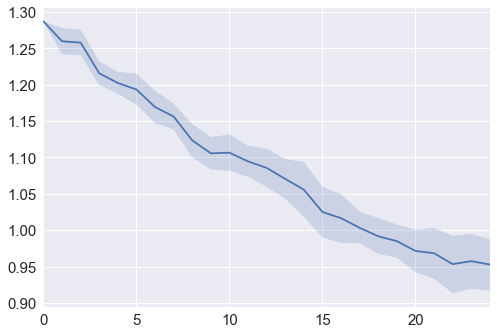

In [32]:
sns.tsplot(sim_distances)

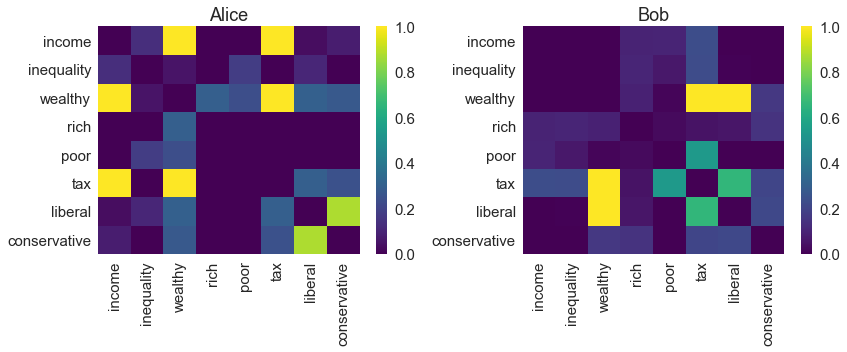

In [356]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(
    alice.episode_graph.adj, 
    xticklabels=alice.episode_graph.labels, 
    yticklabels=alice.episode_graph.labels, 
    cmap='viridis',
    ax=ax1,
)
ax1.set_title('Alice')

sns.heatmap(
    bob.episode_graph.adj, 
    xticklabels=bob.episode_graph.labels, 
    yticklabels=bob.episode_graph.labels, 
    cmap='viridis',
    ax=ax2
)
ax2.set_title('Bob')
plt.tight_layout()

In [357]:
alice.end_episode()
bob.end_episode()

Alice stopped listening
Bob stopped listening


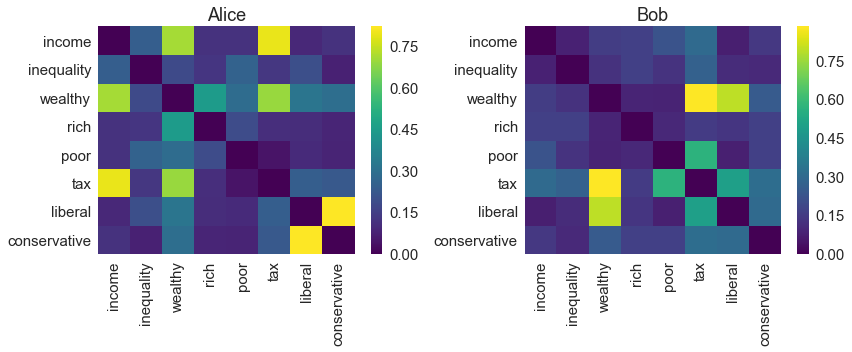

In [358]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(
    alice.graph.adj, 
    xticklabels=alice.graph.labels, 
    yticklabels=alice.graph.labels, 
    cmap='viridis',
    ax=ax1,
)
ax1.set_title('Alice')

sns.heatmap(
    bob.graph.adj, 
    xticklabels=bob.graph.labels, 
    yticklabels=bob.graph.labels, 
    cmap='viridis',
    ax=ax2
)
ax2.set_title('Bob')
plt.tight_layout()

## Network structure

<img src='momennejad_networks.png'>

In [518]:
clustered_adj = np.zeros(shape=(10,10))
clustered_adj[0, (1,2,3)] = 1
clustered_adj[1, (0,2,3)] = 1
clustered_adj[2, (0,1,4)] = 1
clustered_adj[3, (0,1,4)] = 1
clustered_adj[4, (2,3,5)] = 1
clustered_adj[5, (4,6,7)] = 1
clustered_adj[6, (5,8,9)] = 1
clustered_adj[7, (5,8,9)] = 1
clustered_adj[8, (6,7,9)] = 1
clustered_adj[9, (6,7,8)] = 1
print(clustered_adj)

clustered = [
    [
        (0, 2),
        (1, 3),
        (4, 5),
        (7, 9),
        (6, 8)
    ],
    [
        (1, 2),
        (3, 4),
        (5, 7),
        (6, 9)
    ],
    [
        (0, 3),
        (2, 4),
        (5, 6),
        (7, 8)
    ],
    [
        (0, 1),
        (8, 9)
    ]
]

[[ 0.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  0.]]


In [519]:
non_clustered_adj = np.zeros(shape=(10,10))
non_clustered_adj[0, (8,2,3)] = 1
non_clustered_adj[1, (9,2,3)] = 1
non_clustered_adj[2, (0,1,4)] = 1
non_clustered_adj[3, (0,1,4)] = 1
non_clustered_adj[4, (2,3,5)] = 1
non_clustered_adj[5, (4,6,7)] = 1
non_clustered_adj[6, (5,8,9)] = 1
non_clustered_adj[7, (5,8,9)] = 1
non_clustered_adj[8, (6,7,0)] = 1
non_clustered_adj[9, (6,7,1)] = 1
print(non_clustered_adj)

non_clustered = [
    [
        (0, 2),
        (1, 3),
        (4, 5),
        (6, 8),
        (7, 9)
    ],
    [
        (1, 2),
        (3, 4),
        (5, 7),
        (6, 9)
    ],
    [
        (0, 3),
        (2, 4),
        (5, 6),
        (7, 8)
    ],
    [
        (0, 8),
        (1, 9)
    ]
]

[[ 0.  0.  1.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  1.  0.  0.  0.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1.  1.]
 [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  0.]]


In [520]:
words_network = [
    'income',
    'inequality',
    'wealthy',
    'rich',
    'poor',
    'tax',
    'liberal',
    'conservative'
]
dsm_network = sem.semantic_dsm(words_network, google_news)

In [537]:
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
agents_clustered = []
agents_non_clustered = []
for name in names:
    new_dsm = copy.copy(dsm_network)
    np.random.shuffle(new_dsm)
    new_graph = gsn.SemanticGraph(word_dsm=new_dsm, labels=words_network)
    new_agent = Agent(name, graph=new_graph, learning_rate=0.4)
    agents_clustered.append(copy.deepcopy(new_agent))
    agents_non_clustered.append(copy.deepcopy(new_agent))

"Hello world, I'm A."
"Hello world, I'm B."
"Hello world, I'm C."
"Hello world, I'm D."
"Hello world, I'm E."
"Hello world, I'm F."
"Hello world, I'm G."
"Hello world, I'm H."
"Hello world, I'm I."
"Hello world, I'm J."


In [538]:
def converse(agent_a, agent_b, n_exchanges=25):
    agent_a.start_episode()
    agent_b.start_episode()
    
    for t in range(n_exchanges):
        words = agent_a.spontaneous_words(2)
        agent_a.send(receivers=[agent_b], words=words)
        words = agent_b.spontaneous_words(2)
        agent_b.send(receivers=[agent_a], words=words)
    
    agent_a.end_episode()
    agent_b.end_episode()

In [539]:
clustered_graph = csgraph.csgraph_from_dense(clustered_adj)
non_clustered_graph = csgraph.csgraph_from_dense(non_clustered_adj)

clustered_shortest_paths = csgraph.shortest_path(clustered_graph)
non_clustered_shortest_paths = csgraph.shortest_path(non_clustered_graph)

In [540]:
def pairwise_distances(agents, shortest_paths):
    distances = []
    binned_distances = {d: [] for d in np.unique(shortest_paths) if d > 0}
    pairs = list(itertools.combinations(range(len(agents)), 2))
    for i, j in pairs:
        agent_a = agents[i]
        agent_b = agents[j]
        d = dist.correlation(
            dist.squareform(agent_a.graph.adj), 
            dist.squareform(agent_b.graph.adj)
        )
        net_d = shortest_paths[i, j]
        binned_distances[net_d].append(d)
    return (distances, binned_distances)

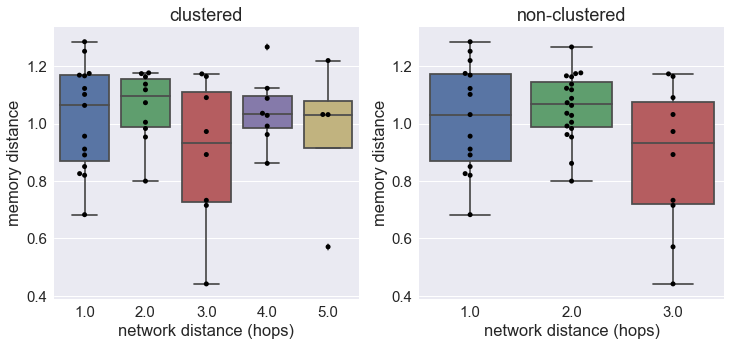

In [543]:
_, clustered_bd = pairwise_distances(agents_clustered, clustered_shortest_paths)
clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clustered_bd.items() ]))

_, non_clustered_bd = pairwise_distances(agents_non_clustered, non_clustered_shortest_paths)
non_clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in non_clustered_bd.items() ]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot(data=pd.DataFrame(clustered_bd_df), ax=ax1)
sns.swarmplot(data=pd.DataFrame(clustered_bd_df), color='black', ax=ax1)
ax1.set_xlabel('network distance (hops)')
ax1.set_ylabel('memory distance')
ax1.set_title('clustered')

sns.boxplot(data=pd.DataFrame(non_clustered_bd_df), ax=ax2)
sns.swarmplot(data=pd.DataFrame(non_clustered_bd_df), color='black', ax=ax2)
ax2.set_xlabel('network distance (hops)')
ax2.set_ylabel('memory distance')
ax2.set_title('non-clustered')

In [544]:
for i, phase in enumerate(clustered):
    print(f"Phase {i}")
    for i, j in phase:
        print(f"{agents_clustered[i].id_string} talks to {agents_clustered[j].id_string}")
        converse(agents_clustered[i], agents_clustered[j], n_exchanges=100)

Phase 0
A talks to C
A is listening
C is listening
A says "conservative rich"
C received ['conservative' 'rich']
C updated their episode graph weights
C says "conservative tax"
A received ['conservative' 'tax']
A updated their episode graph weights
A says "inequality liberal"
C received ['inequality' 'liberal']
C updated their episode graph weights
C says "liberal inequality"
A received ['liberal' 'inequality']
A updated their episode graph weights
A says "tax income"
C received ['tax' 'income']
C updated their episode graph weights
C says "conservative inequality"
A received ['conservative' 'inequality']
A updated their episode graph weights
A says "wealthy tax"
C received ['wealthy' 'tax']
C updated their episode graph weights
C says "inequality income"
A received ['inequality' 'income']
A updated their episode graph weights
A says "liberal poor"
C received ['liberal' 'poor']
C updated their episode graph weights
C says "conservative tax"
A received ['conservative' 'tax']
A updated t

In [545]:
for i, phase in enumerate(non_clustered):
    print(f"Phase {i}")
    for i, j in phase:
        print(f"{agents_non_clustered[i].id_string} talks to {agents_non_clustered[j].id_string}")
        converse(agents_non_clustered[i], agents_non_clustered[j], n_exchanges=100)

Phase 0
A talks to C
A is listening
C is listening
A says "poor liberal"
C received ['poor' 'liberal']
C updated their episode graph weights
C says "rich liberal"
A received ['rich' 'liberal']
A updated their episode graph weights
A says "income inequality"
C received ['income' 'inequality']
C updated their episode graph weights
C says "rich income"
A received ['rich' 'income']
A updated their episode graph weights
A says "conservative inequality"
C received ['conservative' 'inequality']
C updated their episode graph weights
C says "inequality liberal"
A received ['inequality' 'liberal']
A updated their episode graph weights
A says "rich tax"
C received ['rich' 'tax']
C updated their episode graph weights
C says "conservative income"
A received ['conservative' 'income']
A updated their episode graph weights
A says "inequality rich"
C received ['inequality' 'rich']
C updated their episode graph weights
C says "poor wealthy"
A received ['poor' 'wealthy']
A updated their episode graph wei

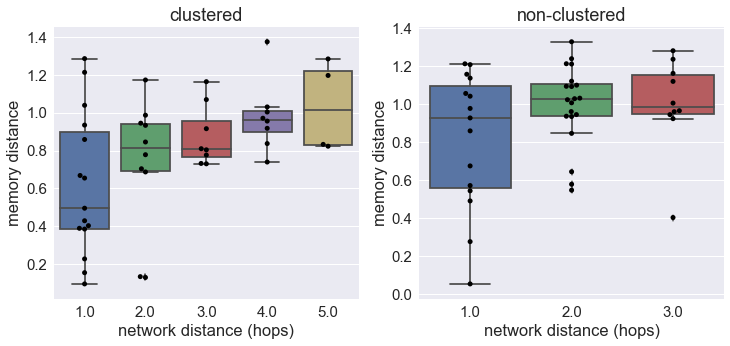

In [546]:
_, clustered_bd = pairwise_distances(agents_clustered, clustered_shortest_paths)
clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clustered_bd.items() ]))

_, non_clustered_bd = pairwise_distances(agents_non_clustered, non_clustered_shortest_paths)
non_clustered_bd_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in non_clustered_bd.items() ]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot(data=pd.DataFrame(clustered_bd_df), ax=ax1)
sns.swarmplot(data=pd.DataFrame(clustered_bd_df), color='black', ax=ax1)
ax1.set_xlabel('network distance (hops)')
ax1.set_ylabel('memory distance')
ax1.set_title('clustered')

sns.boxplot(data=pd.DataFrame(non_clustered_bd_df), ax=ax2)
sns.swarmplot(data=pd.DataFrame(non_clustered_bd_df), color='black', ax=ax2)
ax2.set_xlabel('network distance (hops)')
ax2.set_ylabel('memory distance')
ax2.set_title('non-clustered')

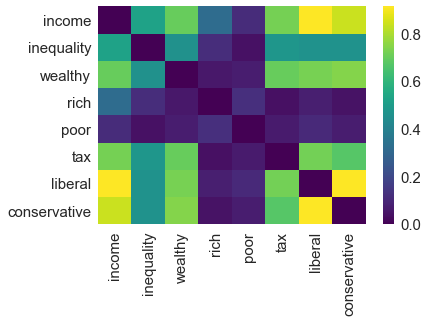

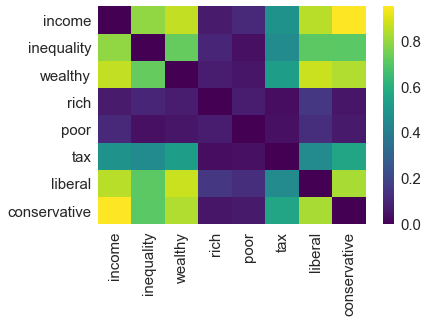

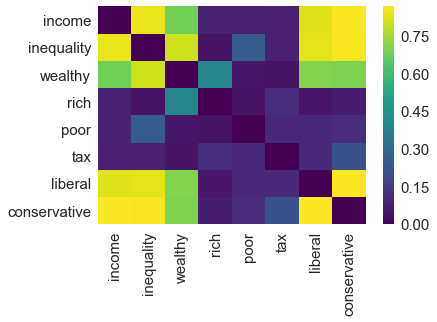

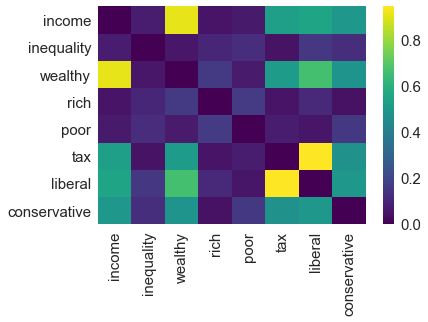

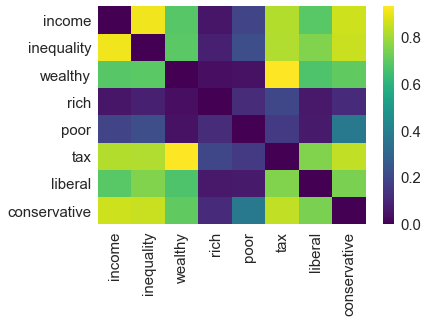

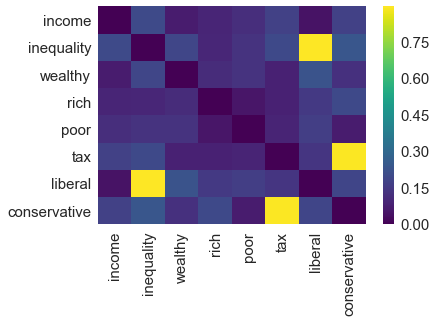

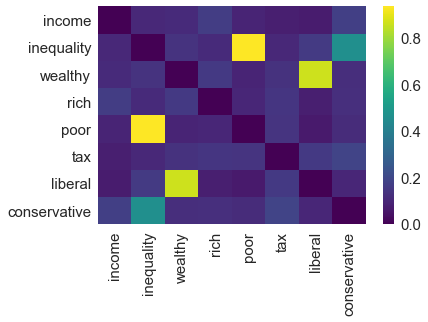

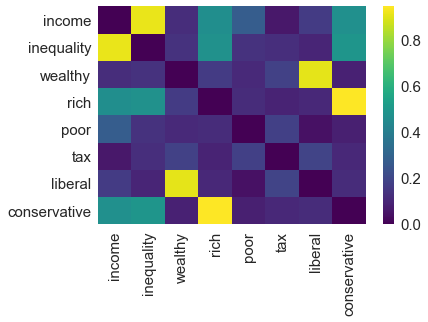

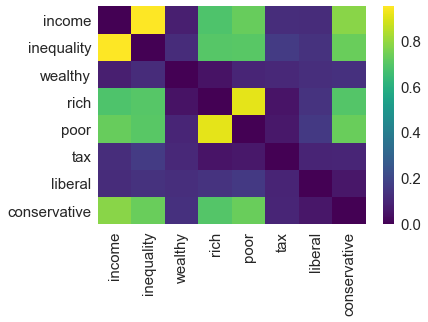

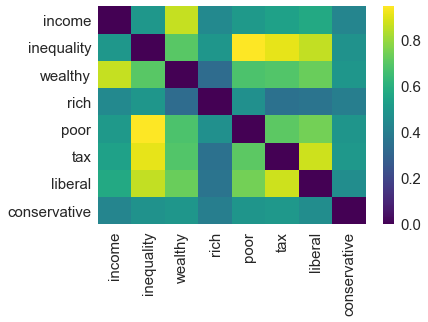

In [548]:
for agent in agents_clustered:
    sns.heatmap(
        agent.graph.adj, 
        xticklabels=agent.graph.labels, 
        yticklabels=agent.graph.labels, 
        cmap='viridis'
    )
    plt.show()